In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets

from sklearn.datasets import make_classification

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc,precision_recall_curve,plot_roc_curve,plot_precision_recall_curve
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix,plot_confusion_matrix



In [18]:
def get_make_classification(n_samples, n_features, n_informative, n_redundant, n_classes):
    
    '''
    We simulate the dataset using random distribution with parameters:
    
    n_samples: number of samples
    
    n_features: number of features
    
    n_informative: The number of informative features. Each class is composed of a number of gaussian clusters 
                   each located around the vertices of a hypercube in a subspace of dimension n_informative. 
                   For each cluster, informative features are drawn independently from N(0, 1) and 
                   then randomly linearly combined within each cluster in order to add covariance. 
                   The clusters are then placed on the vertices of the hypercube.
                   
                   Default: 2
                   
    n_redundant: The number of redundant features. These features are generated as random linear combinations 
                 of the informative features.
                 
                 Default: 2
                 
    n_classes: number of classes
    
    weights: The proportions of samples assigned to each class. 
             If None, then classes are balanced. Note that if len(weights) == n_classes - 1, then the last class weight
             is automatically inferred. More than n_samples samples may be returned if the sum of weights exceeds 1. 
             Note that the actual class proportions will not exactly match weights when flip_y isn’t 0.
    
    flip_y: The fraction of samples whose class is assigned randomly. 
            Larger values introduce noise in the labels and make the classification task harder. 
            Note that the default setting flip_y > 0 might lead to less than n_classes in y in some cases.
            
            Default: 0.01


    '''
    X,y = make_classification(n_samples = n_samples, 
                              n_features = n_features,
                              n_informative = n_informative,
                              n_redundant = n_redundant, 
                              n_classes = n_classes,
                              random_state = 1)
    
    return X,y

In [54]:
'''
Logistic Regression is a classification algorithm for Binary Classification

However, it is possible to use Logistic Regression with MultiClass Classification

using the One Versus All (OVA) (called also One Versus Rest (OVR)) or the One Versus One (OVO) implementation

Useful link:

https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

OVA example:

classes: red, green, blue, yellow

1)binary classification: red, [green, blue,yellow]
2)binary classification: green, [red, blue,yellow]
3)binary classification: blue, [red, green,yellow]
4)binary classification: yellow, [red,green,blue]

>>> N classes, N models

This approach requires that each model predicts a class membership probability or a probability-like score. 
The argmax of these scores (class index with the largest score) is then used to predict a class.

This approach is commonly used for algorithms that naturally predict numerical class membership probability or score, 
such as:

Logistic Regression
Perceptron


A possible downside of this approach is that it requires one model to be created for each class. 
For example, three classes requires three models. 
This could be an issue for large datasets (e.g. millions of rows), slow models (e.g. neural networks), 
or very large numbers of classes (e.g. hundreds of classes).



OVO example:

classes: red, green, blue, yellow

1)binary classification: red, green
2)binary classification: red, blue
3)binary classification: red, yellow
4)binary classification: green, blue
5)binary classification: green, yellow
6)binary classification: blue, yellow

>>> N classes N(N - 1)/2 models

Each binary classification model may predict one class label and the model 
with the most predictions or votes is predicted by the one-vs-one strategy.

Similarly, if the binary classification models predict a numerical class membership, such as a probability, 
then the argmax of the sum of the scores (class with the largest sum score) is predicted as the class label.

Classically, this approach is suggested for support vector machines (SVM) and related kernel-based algorithms. 
This is believed because the performance of kernel methods does not scale in proportion to the size 
of the training dataset and using subsets of the training data may counter this effect.

1) OVO is not reccomended for Logistic Regression, OVA is better
2) In general, it is better to not use Logistic Regression for Multiclass Classification, other algorithms 
such as Linear Discriminant Analysis (LDA) are more robust

'''



def get_logistic_regression(parameters,X_train,y_train):
    
    '''
    penalty: 'l2', 'l1' , 'elasticnet'
            
             Used to specify the norm used in the penalization. 
    
             loss function of Logistic Regression with penalty 'l2':
             
             L(B,C) = C * sum_n [log(exp(-y_i * (X_iT * B + c)) + 1)] + 1/2 * B^2
             
             
             loss function of Logistic Regression with penalty 'l1':
             
             L(B,C) = C * sum_n [log(exp(-y_i * (X_iT * B + c)) + 1)] + 1/2 * ||B||
             
             
             loss function of Logistic Regression with penalty 'elasticnet' (combination of 'l1' and 'l2'):
             
             L(B,C) = C * sum_n [log(exp(-y_i * (X_iT * B + c)) + 1)] + (1 - rho)/2*B^2 + rho * ||B||
             
             rho: l1_ratio >>> controls the strength of the strenght of l2 regularization vs. l1 regularization
             
             
    C: positive float used in the loss function of Logistic Regression
       
       Inverse of regularization strength; must be a positive float. 
       Like in support vector machines, smaller values specify stronger regularization
       
       
    fit_intercept: Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    
    
    multi_class: 'auto', 'ovr', 'multinomial'
             
                 'auto': binary classification
                
                 'ovr': One Versus Rest implentation in case of multiclass label
    
    
    
    '''
    
    # get the parameters of logistic regression
    penalty,C, fit_intercept, multi_class = parameters
    
    # define the logistic regression model
    log_reg = LogisticRegression(penalty = penalty, 
                                 C = C, 
                                 fit_intercept = fit_intercept, 
                                 multi_class = multi_class)
    
    # fit the logistic regression model
    log_reg.fit(X_train, y_train)
    


    return log_reg

In [101]:
def plot_classification_performance(clf,X,y_true, step, binary):
   
    '''
    performance of classification is evaluated with:
    
    1) accuracy: (TP + TN)/(TP + TN + FP + FN)
    
    2) precision: TP / (TP + FP)
    
    3) recall (sensitivity, true positive rate): TP / (TP + FN)
    
    4) f_score: 2 * precision * recall / (precision + recall)
    
    5) precsion_recall_curve: x-axis: precision, y-axis: recall
    
    6) roc_curve: x-axis: true positive rate, y-axis: false positive rate
                
                true positive rate (recall, sensitivity): TP / (TP + FN)
                false positive rate (fall out, 1 - specificity): FP / (FP + TN) = 1 - specificity = 1 - TN / (TN + FP)
                
                specifity (or true negative rate): TN / (TN + FP) 
    
    7) confusion_matrix = [TP  FP
                           FN  TN]  
    
    '''
    
    accuracy = clf.score(X,y_true)
    
    if binary:
    
       
    
        y_pred = clf.predict(X)
        
        report = classification_report(y_true,y_pred)
        print('{} Classification Report'.format(step))
        print(report)
    
    
        plot_roc_curve(clf, X, y_true)
        plt.title('{} ROC curve'.format(step))
    
        plot_precision_recall_curve(clf, X, y_true)
        plt.title('{} Precision Recall curve'.format(step))
        
        
        plot_confusion_matrix(clf,X, y_true)
        plt.title('{} Confusion Matrix'.format(step))
        
    else:
        
        
        n_classes = len(clf.classes_)
        #y_score = clf.predict_proba(X)
        y_score = clf.decision_function(X)
        y_pred = clf.predict(X)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
    
        precision = dict()
        recall = dict()
        f_score = dict()
    
        y_true_dummies = pd.get_dummies(y_true, drop_first = False).values
    
        for i in range(n_classes):
        
            fpr[i], tpr[i], _ = roc_curve(y_true_dummies[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
            precision[i], recall[i],_ =  precision_recall_curve(y_true_dummies[:, i], y_score[:, i])
            
        report = classification_report(y_true,y_pred)
        print('{} Classification Report'.format(step))
        print(report)
                                                                
       
    
        figsize=(8, 5)
        fig, ax = plt.subplots(figsize = figsize)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('{} ROC curve'.format(step))
        
        for i in range(n_classes):
            ax.plot(fpr[i], tpr[i], label = 'Class {} (area = {:.2f})'.format(i, roc_auc[i]))
    
        ax.legend(loc="best")
        ax.grid(alpha=.4)
        sns.despine()
        plt.show()
    
        figsize=(8, 5)
        fig, ax = plt.subplots(figsize = figsize)

        ax.set_xlabel('Precision')
        ax.set_ylabel('Recall')
        ax.set_title('{} Precision Recall curve'.format(step))
        
        for i in range(n_classes):
            ax.plot(precision[i], recall[i], label = 'Class {}'.format(i))
        
        ax.legend(loc="best")
        ax.grid(alpha=.4)
        sns.despine()
        plt.show()
    
        figsize=(8, 5)
        plot_confusion_matrix(clf,X,y_true)
        
        
    

# Binary Classification - Logistic Regression

## 1. Get the dataset

In [102]:
n_samples = 1000
n_features = 30
n_informative = 2
n_redundant = 2

n_classes = 2




X,y = get_make_classification(n_samples, n_features,n_informative,n_redundant,n_classes)

(array([502.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 498.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

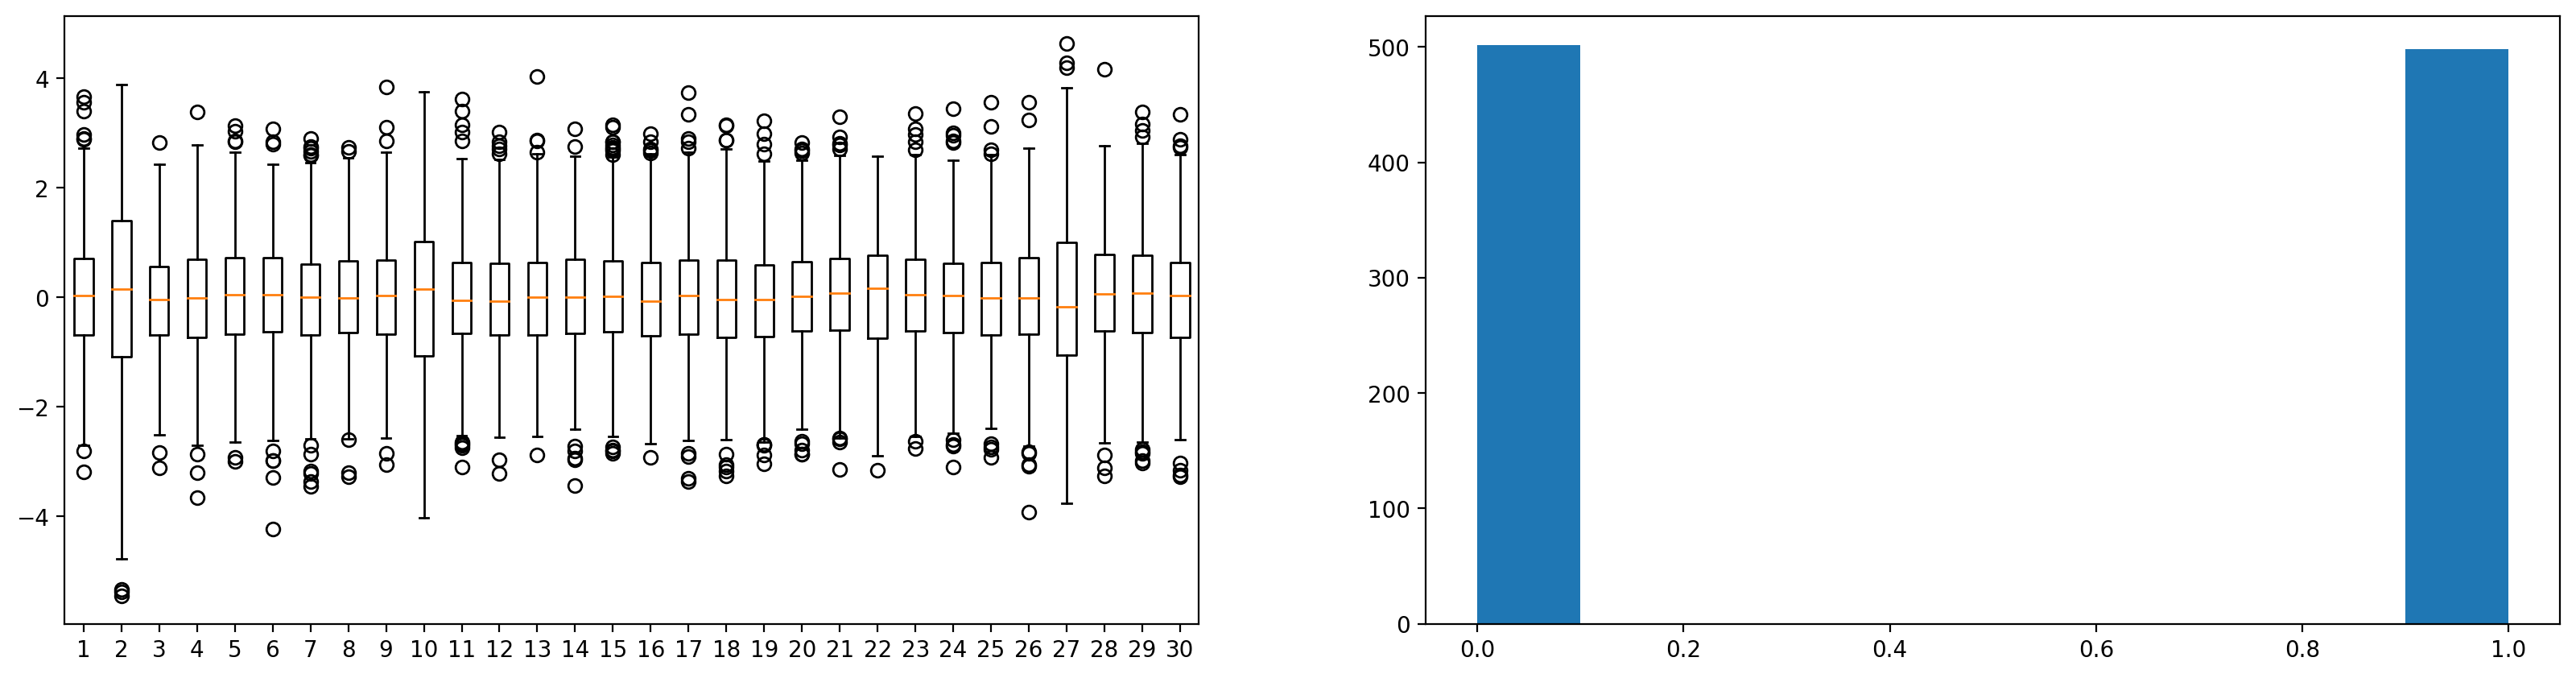

In [103]:
# features distribution after scaling

fig = plt.figure(figsize = (20,5), dpi = 200)

ax = fig.add_subplot(1,2,1)
plt.boxplot(X)

ax = fig.add_subplot(1,2,2)
plt.hist(y)

## 2 Logistic Regression 

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

In [105]:
penalty = 'l2'
C = 1
fit_intercept = True
multi_class = 'auto'

parameters = penalty, C, fit_intercept, multi_class
log_reg = get_logistic_regression(parameters, X_train, y_train)

Train Classification Report
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       327
           1       0.84      0.88      0.86       343

    accuracy                           0.85       670
   macro avg       0.85      0.85      0.85       670
weighted avg       0.85      0.85      0.85       670



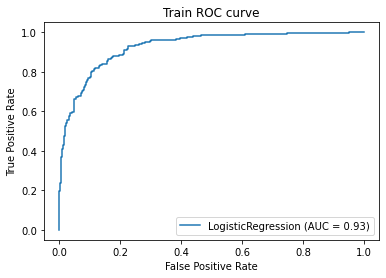

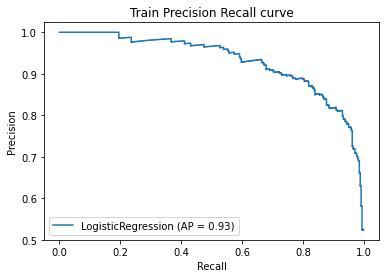

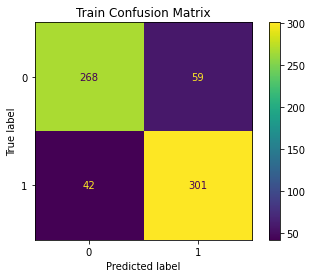

In [106]:
plot_classification_performance(log_reg, X_train,y_train, step ='Train', binary = True)

Test Classification Report
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       175
           1       0.80      0.88      0.84       155

    accuracy                           0.84       330
   macro avg       0.84      0.84      0.84       330
weighted avg       0.84      0.84      0.84       330



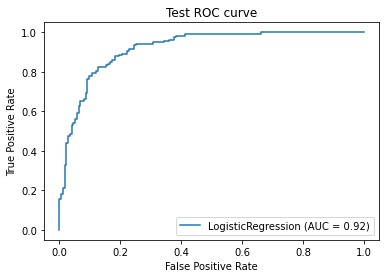

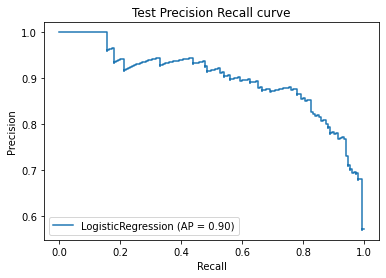

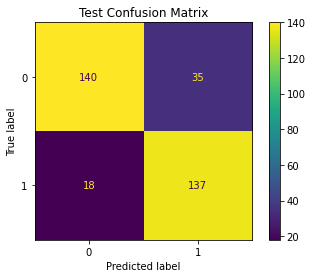

In [107]:
plot_classification_performance(log_reg, X_test,y_test, step ='Test', binary = True)

# Multiclass Classification - Logistic Regression with OVR and OVO

**One Versus Rest(OVR) and One Versus One (OVO)**


https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/

## 1. Get the dataset

In [108]:
n_samples = 1000
n_features = 10
n_informative = 5
n_redundant = 5

n_classes = 5

X,y = get_make_classification(n_samples = n_samples,
                              n_features = n_features,
                              n_informative = n_informative,
                              n_redundant = n_redundant,
                              n_classes = n_classes)
                    

(array([199.,   0., 202.,   0.,   0., 202.,   0., 199.,   0., 198.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

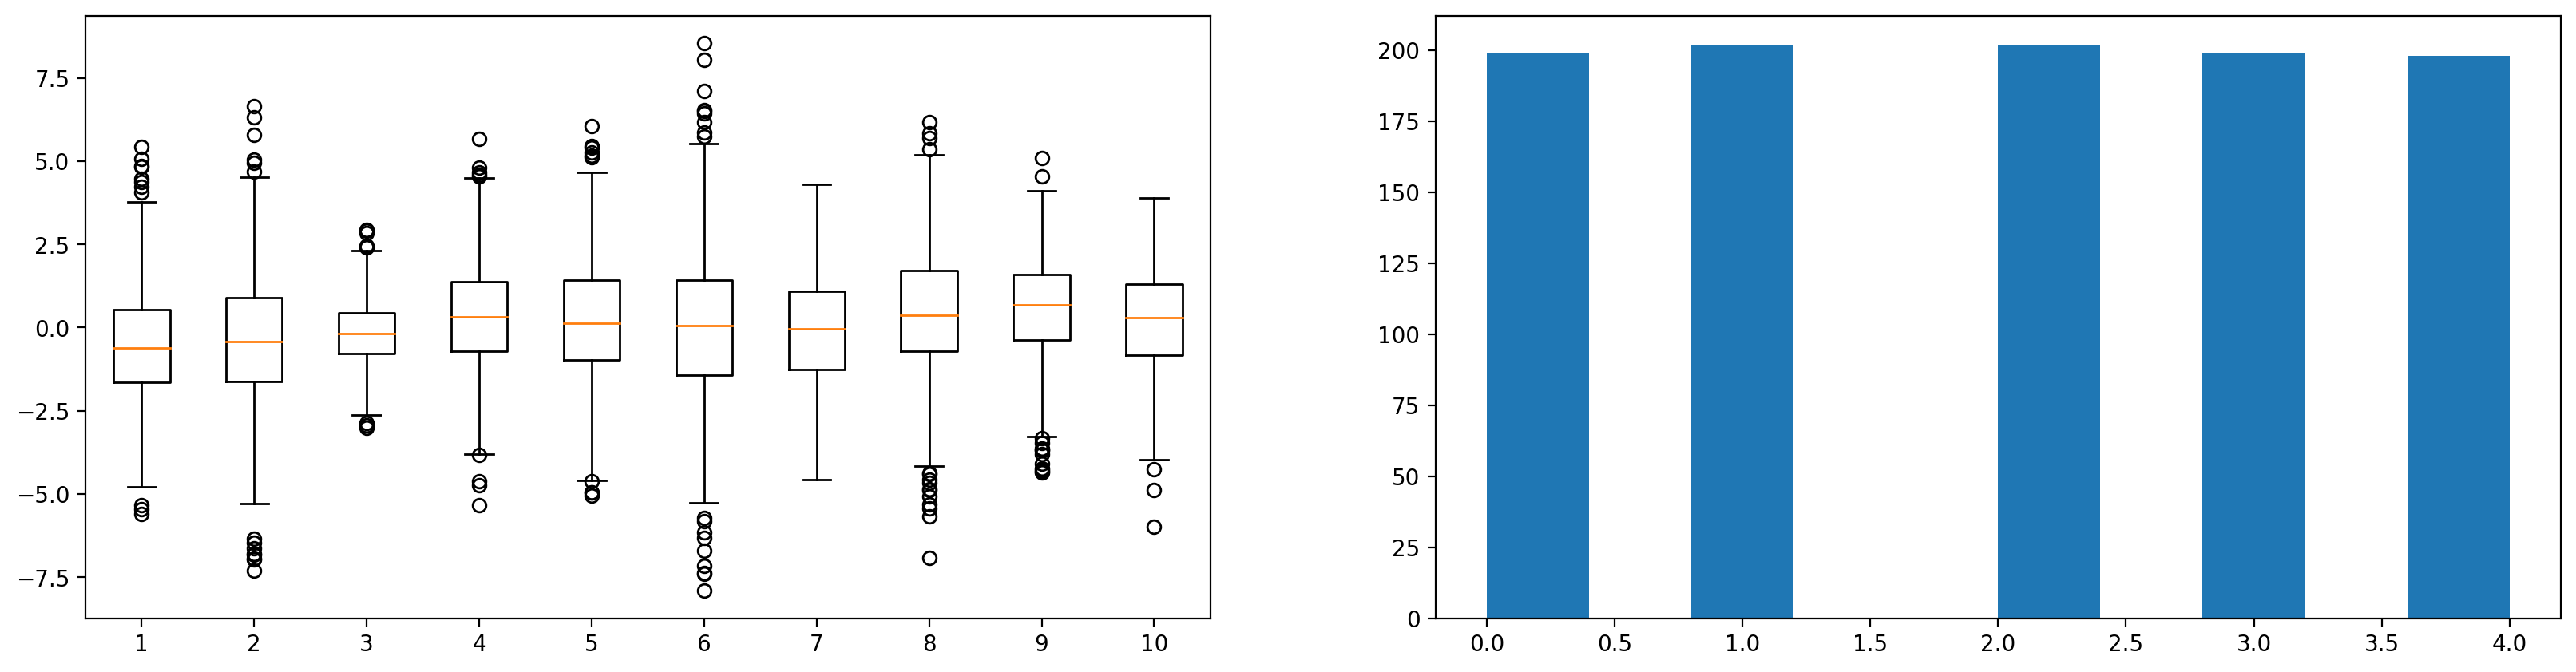

In [109]:
# features distribution after scaling

fig = plt.figure(figsize = (20,5), dpi = 200)

ax = fig.add_subplot(1,2,1)
plt.boxplot(X)

ax = fig.add_subplot(1,2,2)
plt.hist(y)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)

## 2. OVR Logistic Regression automatically implemented in Scikit-Learn

In [111]:
penalty = 'l2'
C = 1
fit_intercept = True
multi_class = 'ovr'

parameters = penalty, C, fit_intercept, multi_class
log_reg = get_logistic_regression(parameters, X_train, y_train)

Train Classification Report
              precision    recall  f1-score   support

           0       0.54      0.57      0.55       129
           1       0.54      0.51      0.52       137
           2       0.64      0.65      0.64       143
           3       0.55      0.50      0.53       129
           4       0.54      0.56      0.55       132

    accuracy                           0.56       670
   macro avg       0.56      0.56      0.56       670
weighted avg       0.56      0.56      0.56       670



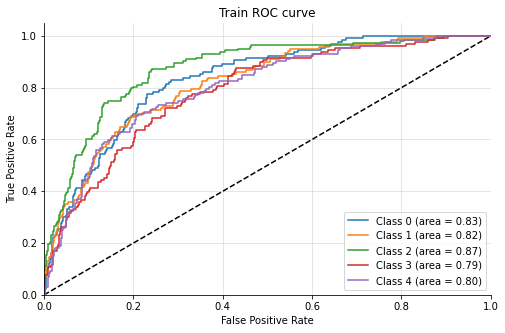

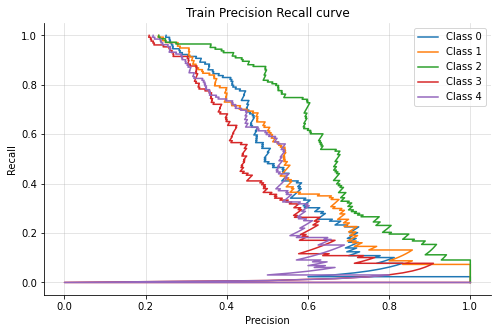

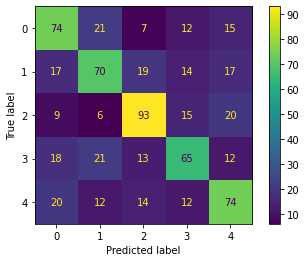

In [112]:
plot_classification_performance(log_reg, X_train,y_train, step ='Train', binary = False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.55      0.53      0.54        70
           1       0.43      0.48      0.45        65
           2       0.50      0.61      0.55        59
           3       0.57      0.44      0.50        70
           4       0.49      0.48      0.49        66

    accuracy                           0.51       330
   macro avg       0.51      0.51      0.51       330
weighted avg       0.51      0.51      0.51       330



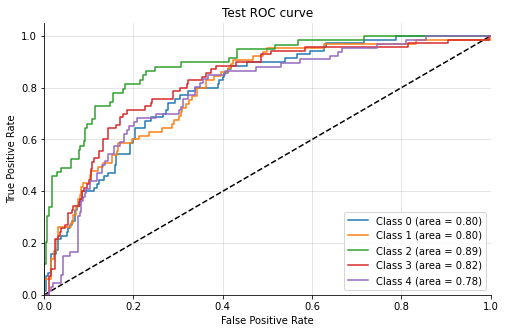

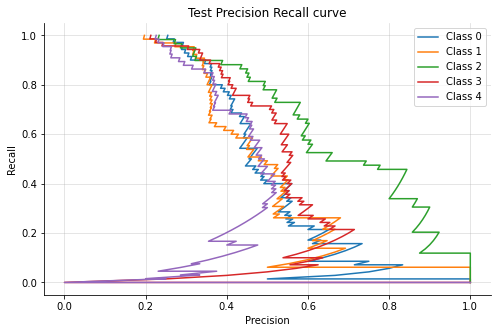

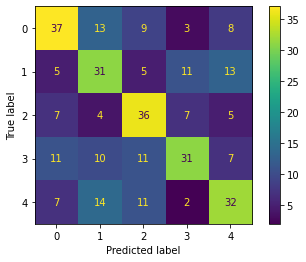

In [113]:
plot_classification_performance(log_reg, X_test,y_test, step ='Test', binary = False)

## 3. OVR using OneVsRestClassifier

In [114]:
penalty = 'l2'
C = 1
fit_intercept = True
multi_class = 'auto'

parameters = penalty, C, fit_intercept, multi_class
log_reg = get_logistic_regression(parameters,X_train, y_train)

ovr = OneVsRestClassifier(log_reg)

ovr.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1))

Train Classification Report
              precision    recall  f1-score   support

           0       0.54      0.57      0.55       129
           1       0.54      0.51      0.52       137
           2       0.64      0.65      0.64       143
           3       0.55      0.50      0.53       129
           4       0.54      0.56      0.55       132

    accuracy                           0.56       670
   macro avg       0.56      0.56      0.56       670
weighted avg       0.56      0.56      0.56       670



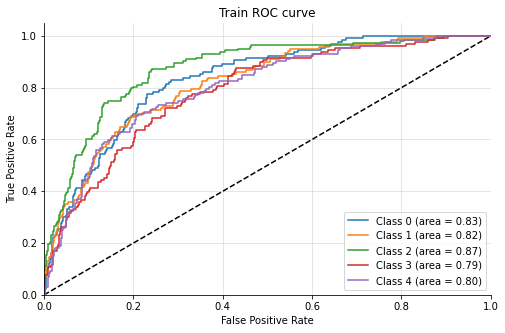

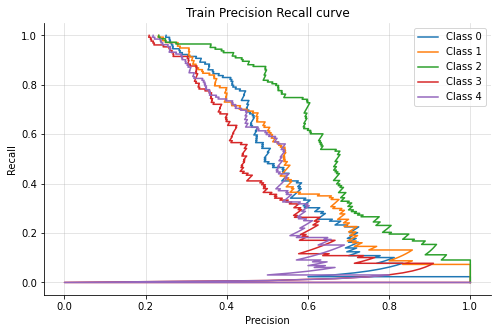

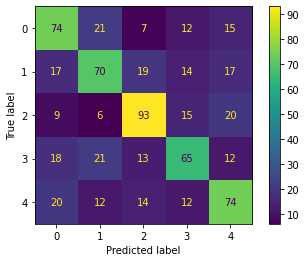

In [115]:
plot_classification_performance(ovr, X_train,y_train, step ='Train', binary = False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.55      0.53      0.54        70
           1       0.43      0.48      0.45        65
           2       0.50      0.61      0.55        59
           3       0.57      0.44      0.50        70
           4       0.49      0.48      0.49        66

    accuracy                           0.51       330
   macro avg       0.51      0.51      0.51       330
weighted avg       0.51      0.51      0.51       330



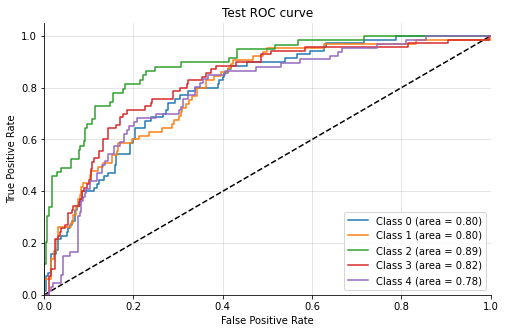

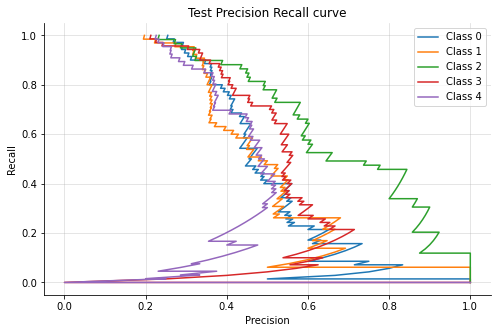

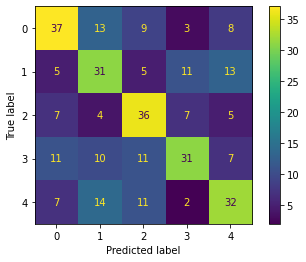

In [116]:
plot_classification_performance(ovr, X_test,y_test, step ='Test', binary = False)

## 3. OVO using OneVsOne

In [126]:
penalty = 'l2'
C = 1.0
fit_intercept = True
multi_class = 'auto'

parameters = penalty, C, fit_intercept, multi_class
log_reg = get_logistic_regression(parameters,X_train, y_train)

ovo = OneVsOneClassifier(log_reg)

ovo.fit(X_train, y_train)

OneVsOneClassifier(estimator=LogisticRegression())

Train Classification Report
              precision    recall  f1-score   support

           0       0.58      0.57      0.57       129
           1       0.53      0.53      0.53       137
           2       0.67      0.64      0.65       143
           3       0.51      0.48      0.49       129
           4       0.55      0.61      0.58       132

    accuracy                           0.57       670
   macro avg       0.57      0.57      0.57       670
weighted avg       0.57      0.57      0.57       670



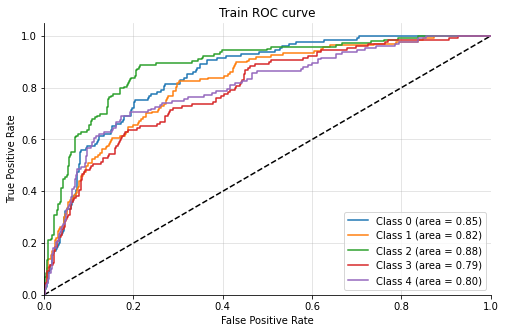

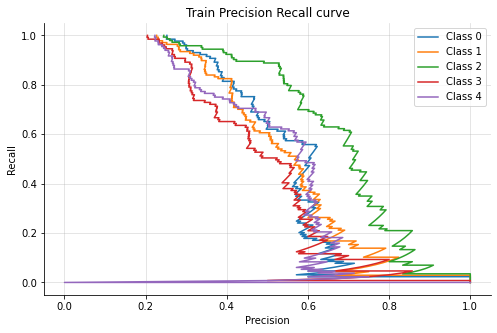

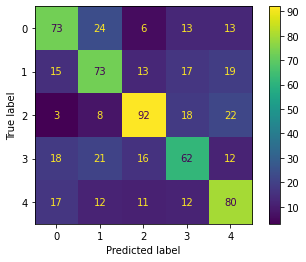

In [127]:
plot_classification_performance(ovo, X_train,y_train, step ='Train', binary = False)

Test Classification Report
              precision    recall  f1-score   support

           0       0.61      0.61      0.61        70
           1       0.43      0.46      0.45        65
           2       0.58      0.63      0.60        59
           3       0.54      0.47      0.50        70
           4       0.50      0.50      0.50        66

    accuracy                           0.53       330
   macro avg       0.53      0.53      0.53       330
weighted avg       0.53      0.53      0.53       330



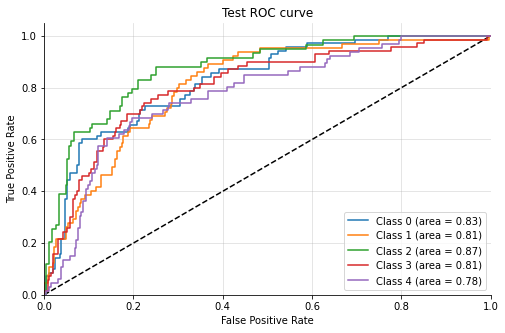

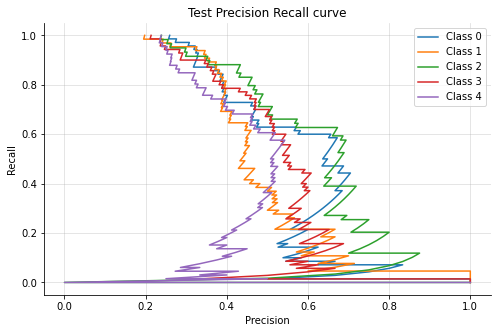

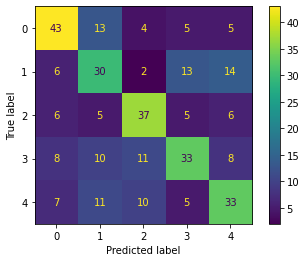

In [128]:
plot_classification_performance(ovo, X_test,y_test, step ='Test', binary = False)